# Table of Contents

1. [Single Run and Snapshot](#key1)<br>
    1.1 [Select Halos by Mass](#singlemass)<br>
    1.2 [Join Halos to Subhalos](#singlejoin)
2. [Single Run and Multiple Snapshots](#key2)<br>
    2.1 [Select Massive Halos in Each Snapshot](#masssnaps)<br>
    2.2 [Calculate Mass Functions](#massfns)
3. [Multiple Runs and Single Snapshot](#key3)
4. [More Complex Examples...](#key4)<br>
    4.1. [Subitem1](#sub1)<br>
    4.2. [Subitem2](#sub2)

### This notebook gives examples of how to interact with the Indra halo database tables on the SciServer.
Indra database tables contain halo and subhalo catalog information and are accessed by executing SQL queries. In many cases querying the database is much faster than reading the binary catalog files. More example queries that might be useful can be found at the [Virgo - Millennium Database](http://gavo.mpa-garching.mpg.de/Millennium/Help?page=demo/genericqueries) pages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import indratools as indra
import pandas as pd
import SciServer.CasJobs as cj

The halo and subhalo catalogs are stored in tables in the 'Indra' database context. There are two tables for each Indra run, from 2_0_0 to 7_7_7, containing FOF group or Subhalo information for every snapshot.

In [2]:
context = "Indra"
X = 2; Y = 3; Z = 4; snapnum = 58
tablename_fof = f'FOF_{X}{Y}{Z}'
tablename_sub = f'SubHalo_{X}{Y}{Z}'

Snapshot redshift and scalefactor information is also stored in a table in the Indra database. **NOTE TO SELF** 'redshift' and 'z' redundant: re-do table?

In [3]:
snaps = cj.executeQuery("select * from Snapshots order by redshift",context)
snaps.columns.values

array(['snapnum', 'redshift', 'time', 'z'], dtype=object)

In [4]:
snaps['z'][snaps['snapnum']==snapnum].values[0]

0.115883

In [ ]:
# Will probably want to say something about limitations of executeQuery (which I don't really know right now)
# and I THINK if submitJob is used instead, the query needs to put results into a temporary table in MyDB? Can't select directly with submitJob?
# e.g,    jobid=cj.submitJob(sql,context) where the sql text selects into MyDB.{table}
#         %time cj.waitForJob(jobid,verbose=True)
#         df=cj.executeQuery("select * from MyDB.{table}".format(table=tablename))    

There are two ways of executing SQL with the SciServer.CasJobs API: `executeQuery` and `submitJob`. **SEE DOCUMENTATION: ...** (executeQuery needs to take less than a minute, plus not have humongous output)

Selecting a full halo catalog at a low-redshift snapshot requires too much memory for the `executeQuery` command. It is better to select only what you need, or if you want to use the entire catalog (FOF + Subhalo) of one snapshot of one Indra run, load the binary catalog with `cat = indra.getsubcat((X,Y,Z),snapnum)`.

Here is a quick way to find out the column names of both tables:

In [24]:
cj.executeQuery(f'select top 1 * from {tablename_fof}',context)
#cj.executeQuery(f"select column_name from information_schema.columns where table_name = N'{tablename_fof}'",context)

,fofId,firstSubhaloId,snapnum,np,numSubs,m_mean200,r_mean200,m_crit200,r_crit200,m_tophat,r_tophat,x,y,z,phKey,vx,vy,vz
0,150390000000,150390000000000,15,23,1,140.6178,0.261417,140.6178,0.261417,140.6178,0.261417,32.63305,784.0032,203.344,40915,19.89944,144.6604,30.09615


In [9]:
cj.executeQuery(f'select top 1 * from {tablename_sub}',context)

,subhaloId,fofId,snapnum,np,x,y,z,phKey,vx,vy,vz,vDisp,vMax,spinX,spinY,spinZ,mostBoundId,halfmassRadius
0,150390000000000,150390000000,15,23,32.63305,784.0032,203.344,40915,19.89944,144.6604,30.09615,284.2457,532.5858,-0.074459,-0.418313,-0.265333,218924066,0.015765


Note that the masses are in units of 1e10 Msun/h (unlike the binary catalog), radii and positions in units of Mpc/h, and velocities in km/s. Note also that in the FOF tables, `np` refers to the number of particles in the main subhalo (e.g. FirstSubOfHalo given by firstSubhaloId) and not the parent FOF group.

# 1. Single Run and Snapshot
<a id="key1"></a>

## Select by mass
<a id="singlemass"></a>

The primary keys are `fofId` and `subhaloId` for the FOF and Subhalo tables. Since they contain the snapshot number, it is faster to search on them then on the `snapnum`. **TO DO** go back to selecting on `snapnum` after I've created indexes on all the tables.

Here we select halos above a given mass from a single run and snapshot. We define the minimum mass in the table's units of 1e10 Msun/h but return masses in units of Msun/h.

In [22]:
bigNumFOF = np.int(1e10)
bigNumSub = np.int(1e3)*bigNumFOF

In [23]:
minmass = 10000.  # minmass = 1e4 corresponds to 1e14 Msun/h.
sql = f"""select np, numSubs, m_crit200*1.0e10 as mass, r_crit200 as radius from {tablename_fof}
    where fofId between {snapnum}*{bigNumFOF} and {snapnum+1}*{bigNumFOF-1} and m_crit200 > {minmass}
    order by mass desc
"""
cj.executeQuery(sql,context)

,np,numSubs,mass,radius
0,34399,21,2.116298e+15,2.252916
1,35976,39,1.970758e+15,2.200039
2,29217,20,1.445832e+15,1.984169
3,27778,19,1.442457e+15,1.982453
4,23411,30,1.411521e+15,1.968359
...,...,...,...,...
11952,2179,3,1.000496e+14,0.814434
11953,1473,2,1.000496e+14,0.813710
11954,2762,9,1.000496e+14,0.814338
11955,1470,5,1.000496e+14,0.813184


In [25]:
sql = f"""select top 5 np, snapnum, subhaloId from {tablename_sub}
    where subhaloId between {snapnum}*{bigNumSub} and {snapnum+1}*{bigNumSub-1}
"""
cj.executeQuery(sql,context)

,np,snapnum,subhaloId
0,14300,58,580000000000000
1,442,58,580000000000001
2,150,58,580000000000002
3,45,58,580000000000003
4,44,58,580000000000004


## Select by mass and select subhalos
<a id="singlejoin"></a>

Here we again select halos above a given mass from a given run and snapshot. We also return subhalos of these halos using SQL `inner join` and the positions of the subhalos. (Note that masses are only defined for FOF groups == main subhalos). We define a new column that keeps track of whether the halo is the main subhalo of the FOF group or not, using SQL `case when` syntax.

In [26]:
minmass = 10000.  # So minmass = 1e4 corresponds to 1e14 Msun/h.
sql = f"""select h.fofId, s.subhaloId, s.x, s.y, s.z, 
        case when h.firstSubhaloId = s.subhaloId then 1 else 0 end as isMain
    from {tablename_fof} h inner join {tablename_sub} s 
    on h.fofId = s.fofId
    and h.fofId between {snapnum}*{bigNumFOF} and {snapnum+1}*{bigNumFOF-1} and h.m_crit200 > {minmass}
"""
df = cj.executeQuery(sql,context)
df

,fofId,subhaloId,x,y,z,isMain
0,580030000013,580030000013000,96.98681,26.78575,186.4446,1
1,580030000013,580030000013001,97.28732,26.48724,186.0073,0
2,580030000013,580030000013002,97.09623,26.42910,185.3907,0
3,580030000014,580030000014000,57.92788,101.50770,144.1088,1
4,580030000014,580030000014001,57.30006,99.97646,142.5220,0
...,...,...,...,...,...,...
50627,580560000010,580560000010005,438.01500,825.57890,168.1203,0
50628,580560000010,580560000010006,439.01390,826.66910,168.4584,0
50629,580560000042,580560000042000,410.24360,914.72090,142.2847,1
50630,580560000042,580560000042001,410.59960,913.41110,142.0255,0


Let's plot them! We'll restrict the plot to a sub-volume of the full Gpc/h cube.

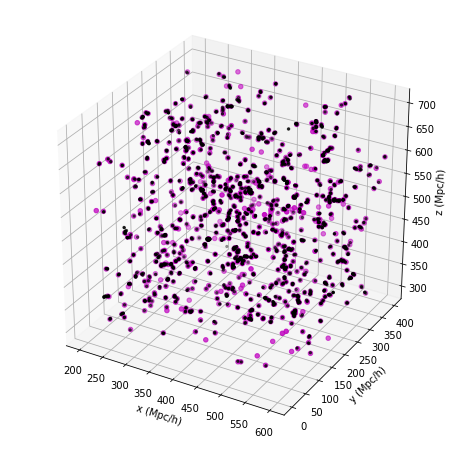

In [27]:
subdf = df[((df['x'] > 200) & (df['x'] < 600) & (df['y'] < 400) & (df['z'] > 300) & (df['z'] < 700))]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(subdf['x'][subdf['isMain']==0].values,subdf['y'][subdf['isMain']==0].values,subdf['z'][subdf['isMain']==0].values,marker='.',color='k')
ax.scatter(subdf['x'][subdf['isMain']==1].values,subdf['y'][subdf['isMain']==1].values,subdf['z'][subdf['isMain']==1].values,marker='o',color='m')
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)');

# 2. Single Run and Multiple Snapshots
<a id="key2"></a>

## Select massive halos in each snapshot
<a id="masssnaps"></a>

In this example we'll select the most massive halo from each snapshot of a given run, while noting that the most massive halo won't necessarily be "the same" halo across snapshots.

Since this query can take some time, we will use `submitJob` instead of `executeQuery` and save the results to a new table in your personal `MyDB` database context. We first need to drop this table if it already exists, e.g. if you have run this example before and want to run it again.

In [68]:
# We create a table in your MyDB below: if you do have done this already, first drop the table
temptable = f'massive_{X}{Y}{Z}'
sql="""IF OBJECT_ID('{table}', 'U') IS NOT NULL 
  DROP TABLE {table}
""".format(table=temptable)
cj.executeQuery(sql,"MyDB")

,Rows Affected
0,0


Selecting the most massive halo in SQL uses the aggregate function `MAX` with the `GROUP BY` syntax to aggregate by `snapnum`. Then, selecting other columns that correspond to this maximum-mass halo row uses `join` on the results of the aggregating `select` clause.

**TO DO:** Use Gerard's better `rank by` syntax. (Takes under a minute, so we wouldn't need to `submitJob`

In [ ]:
sql = f"""select h.snapnum, h.np, h.numSubs, h.r_crit200 as radius, h.m_crit200*1.0e10 as mass,
        h.x, h.y, h.z
    into MyDB.{temptable}
    from {tablename_fof} h join (select MAX(m_crit200) as mass, snapnum FROM {tablename_fof} GROUP BY snapnum) max
        on h.m_crit200 = max.mass and h.snapnum = max.snapnum
"""
jobid = cj.submitJob(sql,context)
cj.waitForJob(jobid,verbose=True)

In [93]:
df = cj.executeQuery('select * from MyDB.{} order by snapnum'.format(temptable))
df[:8]

,snapnum,np,numSubs,radius,mass,x,y,z
0,15,30,1,0.265511,1.757722e+12,236.3941,112.0773,781.6100
1,16,35,1,0.323328,2.460811e+12,236.5246,112.0514,781.6426
2,17,78,1,0.381431,3.585754e+12,236.7110,112.1097,781.7067
3,18,94,1,0.453455,6.046565e+12,236.9895,112.0399,781.6568
4,19,119,1,0.503971,8.366758e+12,237.0539,111.9012,781.6778
5,20,158,1,0.534648,9.983863e+12,237.3519,112.0080,781.6508
6,21,193,1,0.574975,1.237437e+13,237.3902,111.7825,781.6188
7,22,264,1,0.614943,1.504610e+13,436.3193,381.2192,248.3477


For fun let's plot the halo positions and color them by their `snapnum`.

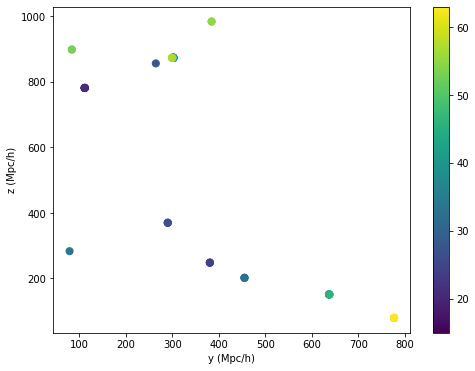

In [91]:
fig = plt.figure(figsize=(8,6))
plt.scatter(df['y'],df['z'],marker='o',s=50,c=df['snapnum'].values)
plt.colorbar()
plt.xlabel('y (Mpc/h)')
plt.ylabel('z (Mpc/h)');

## Calculate Mass Functions 
<a id="massfns"></a>

select mass functions in SQL for every snapshot in one query.... this is Millennium demo H5...

**TO DO:** get correct mass units, figure out how to group resulting table, handle empty bins, and plot

In [ ]:

sql = f"""select snapnum,power(10.00,.1*floor(log10(m_crit200)/.1)) as m, count(*) as num
    from {tablename_fof}
    where m_crit200 > 0
    group by  snapnum, floor(log10(m_crit200)/.1)
    order by 1 desc, 2
"""


# 3. Multiple Runs and Single Snapshot
<a id="key3"></a>

In [ ]:
# - select most massive halo from all runs for a given snapshot
# DO I even know how to do this? Need to aggregate across/select from many tables... but if it's possible, might be faster than reading hundreds of binary file catalogs...
# Maybe need to create a python function that can loop over tablenames for each run.... each selects most massive halo in given snapshot into new row of a MyDB table?
# ... otherwise, don't want to write single SQL query that has names of hundreds of tables and does hundreds of joins...

# More Complex Thing (like lightcone?)
<a id="key4"></a>

In [ ]:
# Is the "SimulationDB" context open to all or limited to a group? That is where the Shape, Box, etc. functions are for spatial queries
# FOR THAT MATTER, is the "Indra" context currently open to all?